In [1]:
# Version Check
import sys
import tensorflow as tf
import tensorflow_datasets as tfds
import PIL
import pandas as pd
import numpy as np
import scipy
print("python", sys.version)
print("tensorflow", tf.__version__)
print("tensorflow-datasets", tfds.__version__)
print("Pillow", PIL.__version__)
print("pandas", pd.__version__)
print("numpy", np.__version__)
print("scipy", scipy.__version__)
print()
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("Built with GPU support:", tf.test.is_built_with_gpu_support())

python 3.8.0 (default, Nov  6 2019, 16:00:02) [MSC v.1916 64 bit (AMD64)]
tensorflow 2.6.2
tensorflow-datasets 4.4.0
Pillow 8.3.2
pandas 1.3.3
numpy 1.19.5
scipy 1.7.1

Num GPUs Available: 1
Built with CUDA: True
Built with GPU support: True


## 1. Load data / Preprocessing

In [2]:
# load data
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_valid, y_valid) = mnist.load_data()
print('train_set:', x_train.shape, y_train.shape)
print('valid_set:', x_valid.shape, y_valid.shape)

train_set: (60000, 28, 28) (60000,)
valid_set: (10000, 28, 28) (10000,)


In [3]:
# add a new label for y_train (odd: 1, even: 0)
y_train_odd = []

for y in y_train:
    if y % 2 == 0:
        y_train_odd.append(0)
    else:
        y_train_odd.append(1)

y_train_odd = np.array(y_train_odd)
y_train_odd.shape

(60000,)

In [4]:
# check the result
print(y_train[:10])
print(y_train_odd[:10])

[5 0 4 1 9 2 1 3 1 4]
[1 0 0 1 1 0 1 1 1 0]


In [5]:
# add a new label for y_valid (odd: 1, even: 0)

y_valid_odd = []

for y in y_valid:
    if y % 2 == 0:
        y_valid_odd.append(0)
    else:
        y_valid_odd.append(1)

y_valid_odd = np.array(y_valid_odd)
y_valid_odd.shape

(10000,)

In [6]:
# normalization
x_train = x_train / 255.0
x_valid = x_valid / 255.0

In [7]:
# add a channel
x_train_in = tf.expand_dims(x_train, -1)  # -1: index -> at the end
x_valid_in = tf.expand_dims(x_valid, -1)  # -1: index -> at the end

In [8]:
print('train_set:', x_train_in.shape, y_train.shape, y_train_odd.shape)
print('valid_set:', x_valid_in.shape, y_valid.shape, y_valid_odd.shape)

train_set: (60000, 28, 28, 1) (60000,) (60000,)
valid_set: (10000, 28, 28, 1) (10000,) (10000,)


## 2. Functional API - concatenate

In [9]:
# model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Concatenate, Dense
from tensorflow.keras.models import Model

inputs = Input(shape=(28, 28, 1))

conv = Conv2D(32, (3, 3), activation='relu')(inputs)
pool = MaxPooling2D((2, 2))(conv)
flat = Flatten()(pool)

flat_inputs = Flatten()(inputs)

concat = Concatenate()([flat, flat_inputs])
outputs = Dense(10, activation='softmax')(concat)

model = Model(inputs=inputs, outputs=outputs)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 26, 26, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 13, 13, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 5408)         0           max_pooling2d[0][0]              
______________________________________________________________________________________________

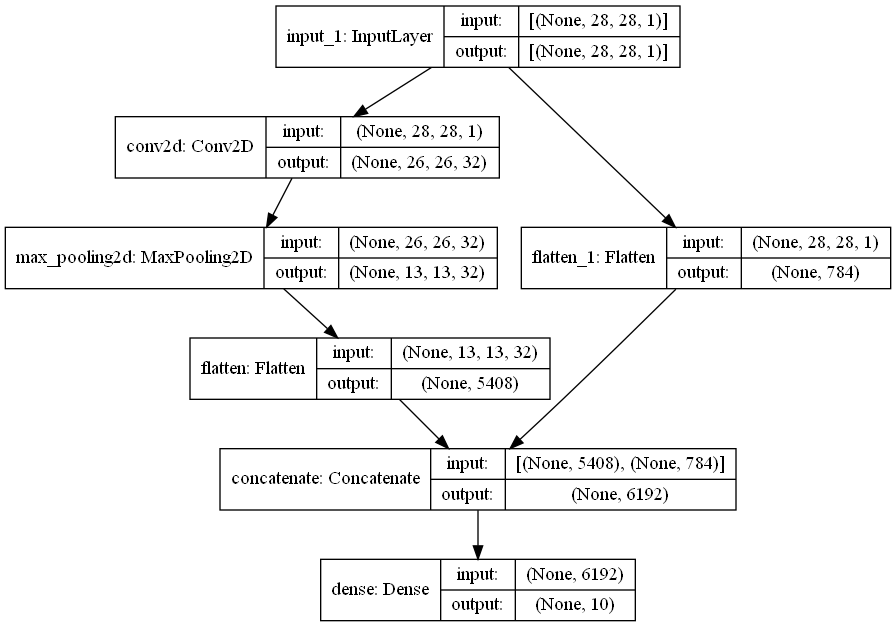

In [11]:
from tensorflow.python.keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='functional_cnn.png')

In [12]:
# compile
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

# fit
history = model.fit(x_train_in, y_train, 
                    validation_data=(x_valid_in, y_valid), 
                    epochs=10)

Epoch 1/10
1875/1875 [==============================] - 8s 2ms/step - loss: 0.1976 - acc: 0.9444 - val_loss: 0.0831 - val_acc: 0.9736
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0740 - acc: 0.9786 - val_loss: 0.0631 - val_acc: 0.9800
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0566 - acc: 0.9829 - val_loss: 0.0603 - val_acc: 0.9805
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0471 - acc: 0.9859 - val_loss: 0.0570 - val_acc: 0.9815
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0383 - acc: 0.9885 - val_loss: 0.0522 - val_acc: 0.9829
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0335 - acc: 0.9892 - val_loss: 0.0710 - val_acc: 0.9793
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0279 - acc: 0.9913 - val_loss: 0.0598 - val_acc: 0.9829
Epoch 8/10
1875/1875 [==============================] - 4s 2ms

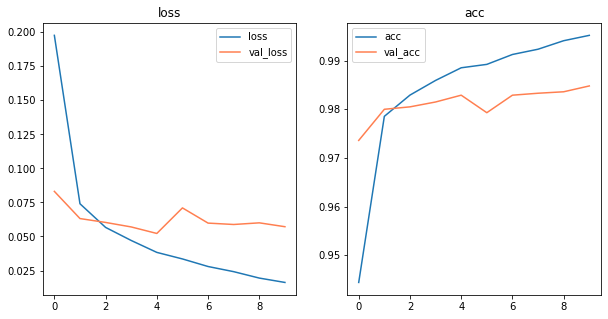

In [13]:
import matplotlib.pylab as plt

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax1.plot(history.history['loss'], label='loss')
ax1.plot(history.history['val_loss'], label='val_loss', color='coral')
ax1.legend()
ax1.set_title('loss')

ax2.plot(history.history['acc'], label='acc')
ax2.plot(history.history['val_acc'], label='val_acc', color='coral')
ax2.legend()
ax2.set_title('acc')

plt.show()

## 3. Functional API - multi-output model
 - output1: predict digit (0 ~ 9)
 - output2: predict odd

In [14]:
# model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Concatenate, Dense
from tensorflow.keras.models import Model

inputs = Input(shape=(28, 28, 1), name='inputs')

conv = Conv2D(32, (3, 3), activation='relu', name='conv2d_layer')(inputs)
pool = MaxPooling2D((2, 2), name='maxpool_layer')(conv)
flat = Flatten(name='flatten_layer')(pool)

flat_inputs = Flatten()(inputs)

concat = Concatenate()([flat, flat_inputs])

digit_outputs = Dense(10, activation='softmax', name='digit_dense')(concat)
odd_outputs = Dense(1, activation='sigmoid', name='odd_dense')(flat_inputs)

model = Model(inputs=inputs, outputs=[digit_outputs, odd_outputs])

In [15]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_layer (Conv2D)           (None, 26, 26, 32)   320         inputs[0][0]                     
__________________________________________________________________________________________________
maxpool_layer (MaxPooling2D)    (None, 13, 13, 32)   0           conv2d_layer[0][0]               
__________________________________________________________________________________________________
flatten_layer (Flatten)         (None, 5408)         0           maxpool_layer[0][0]              
____________________________________________________________________________________________

In [16]:
model.input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'inputs')>

In [17]:
model.output

[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'digit_dense')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'odd_dense')>]

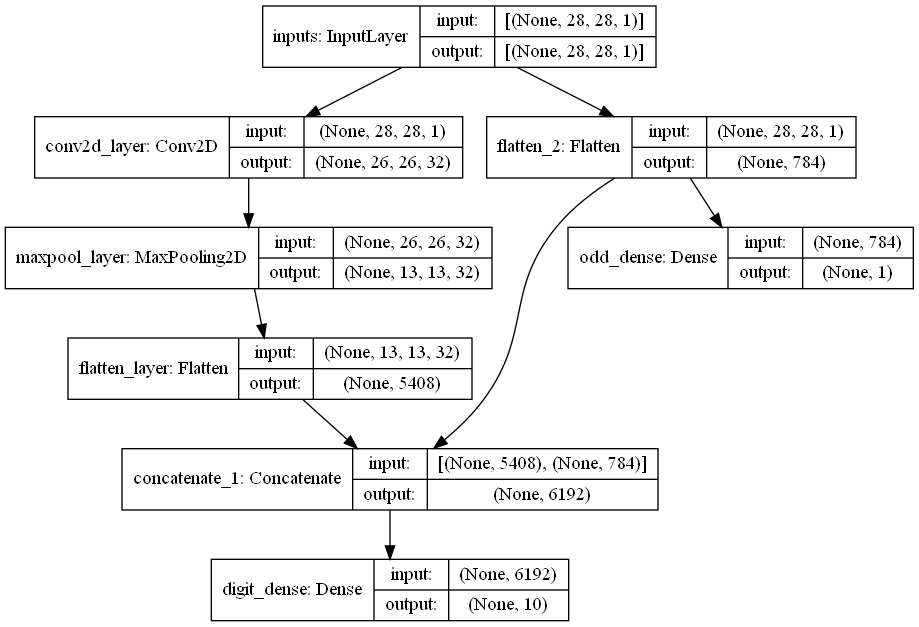

In [18]:
from tensorflow.python.keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='multi_output_cnn.png')

In [19]:
# compile
model.compile(optimizer='adam', 
              loss={'digit_dense': 'sparse_categorical_crossentropy', 'odd_dense': 'binary_crossentropy'},  # {layer_name: }
              loss_weights={'digit_dense': 1, 'odd_dense': 0.5},                                            # {layer_name: }
              metrics=['acc'])

In [20]:
# fit
history = model.fit({'inputs': x_train_in},                                               # x_train
                    {'digit_dense': y_train, 'odd_dense': y_train_odd},                   # y_train
                    validation_data=({'inputs': x_valid_in},                              # x_valid
                                     {'digit_dense': y_valid, 'odd_dense': y_valid_odd}), # y_valid
                    epochs=10)

Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3860 - digit_dense_loss: 0.2233 - odd_dense_loss: 0.3253 - digit_dense_acc: 0.9371 - odd_dense_acc: 0.8626 - val_loss: 0.2377 - val_digit_dense_loss: 0.0999 - val_odd_dense_loss: 0.2757 - val_digit_dense_acc: 0.9728 - val_odd_dense_acc: 0.8901
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2218 - digit_dense_loss: 0.0860 - odd_dense_loss: 0.2716 - digit_dense_acc: 0.9751 - odd_dense_acc: 0.8919 - val_loss: 0.2002 - val_digit_dense_loss: 0.0677 - val_odd_dense_loss: 0.2650 - val_digit_dense_acc: 0.9790 - val_odd_dense_acc: 0.8959
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1953 - digit_dense_loss: 0.0639 - odd_dense_loss: 0.2628 - digit_dense_acc: 0.9808 - odd_dense_acc: 0.8957 - val_loss: 0.1910 - val_digit_dense_loss: 0.0613 - val_odd_dense_loss: 0.2596 - val_digit_dense_acc: 0.9811 - val_odd_dense_acc: 0.8991
Epoch 4/10
1875/1875 [============

In [21]:
EVAL = model.evaluate({'inputs': x_valid_in}, {'digit_dense': y_valid, 'odd_dense': y_valid_odd})
EVAL

313/313 [==============================] - 1s 3ms/step - loss: 0.1928 - digit_dense_loss: 0.0640 - odd_dense_loss: 0.2576 - digit_dense_acc: 0.9819 - odd_dense_acc: 0.8995


[0.19283689558506012,
 0.06401228904724121,
 0.2576492130756378,
 0.9818999767303467,
 0.8995000123977661]

In [22]:
# digit, odd
EVAL[3], EVAL[4]

# there might be more layers needed for odd 

(0.9818999767303467, 0.8995000123977661)

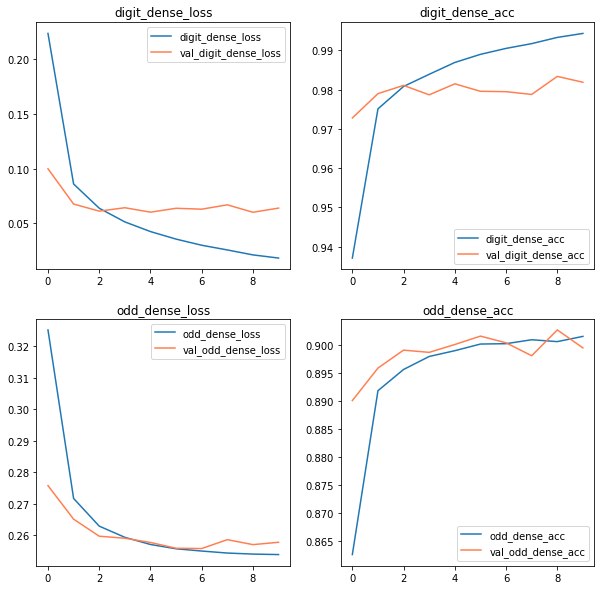

In [23]:
import matplotlib.pylab as plt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

ax1.plot(history.history['digit_dense_loss'], label='digit_dense_loss')
ax1.plot(history.history['val_digit_dense_loss'], label='val_digit_dense_loss', color='coral')
ax1.legend()
ax1.set_title('digit_dense_loss')

ax2.plot(history.history['digit_dense_acc'], label='digit_dense_acc')
ax2.plot(history.history['val_digit_dense_acc'], label='val_digit_dense_acc', color='coral')
ax2.legend()
ax2.set_title('digit_dense_acc')

ax3.plot(history.history['odd_dense_loss'], label='odd_dense_loss')
ax3.plot(history.history['val_odd_dense_loss'], label='val_odd_dense_loss', color='coral')
ax3.legend()
ax3.set_title('odd_dense_loss')

ax4.plot(history.history['odd_dense_acc'], label='odd_dense_acc')
ax4.plot(history.history['val_odd_dense_acc'], label='val_odd_dense_acc', color='coral')
ax4.legend()
ax4.set_title('odd_dense_acc')

plt.show()

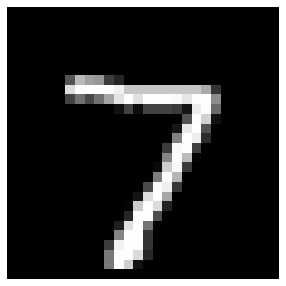

In [24]:
import matplotlib.pylab as plt  # .pylab

def plot_image(data, idx):
    plt.figure(figsize=(5, 5))
    plt.imshow(data[idx], cmap='gray')
    plt.axis('off')
    plt.show()

plot_image(x_valid, 0)

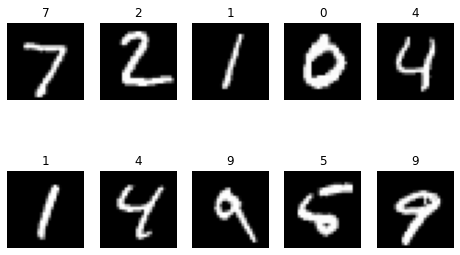

In [25]:
import matplotlib.pylab as plt  # .pylab

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(8, 5))
    
for i in range(10):
    ax = axes[i//5, i%5]
    ax.imshow(x_valid[i], cmap='gray')
    ax.axis('off')
    ax.set_title(str(y_valid[i]))
        
plt.show()  

In [26]:
# predict
digit_preds, odd_preds = model.predict(x_valid_in)
print(digit_preds[0])
print(odd_preds[0])

[3.2430070e-13 1.0061095e-09 8.9182789e-10 3.0482238e-07 2.5803496e-12
 2.8387674e-13 1.9310040e-20 9.9999964e-01 3.9993666e-09 9.2434516e-10]
[0.999566]


In [27]:
# convert probs to labels
digit_labels = np.argmax(digit_preds, axis=1)  # axis=-1, the last dimension
digit_labels[:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 6, 9], dtype=int64)

In [28]:
# convert probs to labels
odd_labels = (odd_preds > 0.5).astype(np.int).reshape(1, -1)[0]
odd_labels[:10]

array([1, 0, 1, 0, 0, 1, 1, 1, 0, 1])

## 3-1. Functional API - multi-output model (enhanced)
 - output1: predict digit (0 ~ 9)
 - output2: predict odd

In [29]:
# model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Concatenate, Dense
from tensorflow.keras.models import Model

inputs = Input(shape=(28, 28, 1), name='inputs')

conv = Conv2D(32, (3, 3), activation='relu', name='conv2d_layer')(inputs)
pool = MaxPooling2D((2, 2), name='maxpool_layer')(conv)
flat = Flatten(name='flatten_layer')(pool)

flat_inputs = Flatten()(inputs)
dense1 = Dense(256, name='dense1')(flat_inputs)
dense2 = Dense(128, name='dense2')(dense1)

concat = Concatenate()([flat, flat_inputs])

digit_outputs = Dense(10, activation='softmax', name='digit_dense')(concat)
odd_outputs = Dense(1, activation='sigmoid', name='odd_dense')(dense2)

model = Model(inputs=inputs, outputs=[digit_outputs, odd_outputs])

In [30]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_layer (Conv2D)           (None, 26, 26, 32)   320         inputs[0][0]                     
__________________________________________________________________________________________________
maxpool_layer (MaxPooling2D)    (None, 13, 13, 32)   0           conv2d_layer[0][0]               
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 784)          0           inputs[0][0]                     
____________________________________________________________________________________________

In [31]:
model.input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'inputs')>

In [32]:
model.output

[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'digit_dense')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'odd_dense')>]

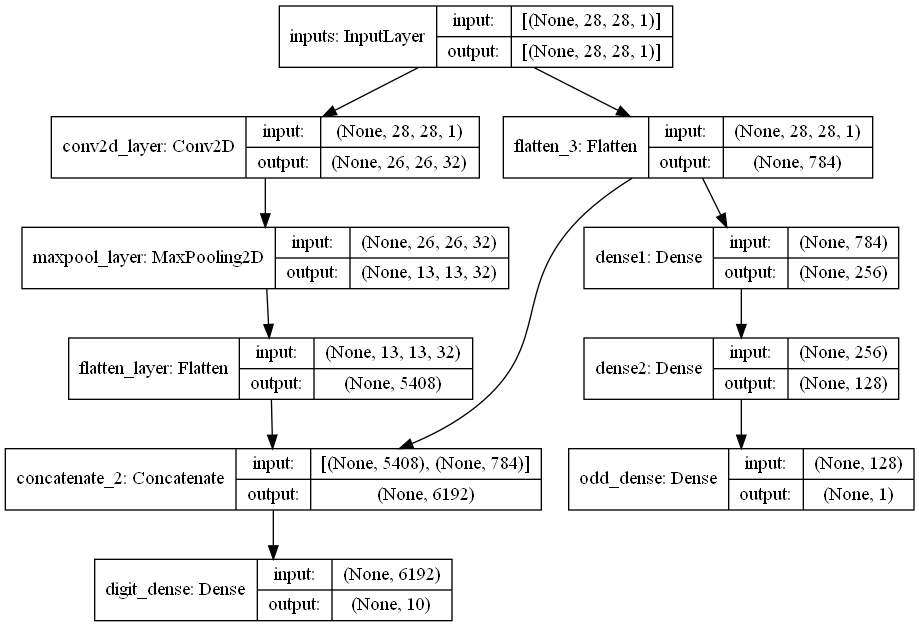

In [33]:
from tensorflow.python.keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='multi_output_cnn_enhanced.png')

In [34]:
# compile
model.compile(optimizer='adam', 
              loss={'digit_dense': 'sparse_categorical_crossentropy', 'odd_dense': 'binary_crossentropy'},  # {layer_name: }
              loss_weights={'digit_dense': 1, 'odd_dense': 0.5},                                            # {layer_name: }
              metrics=['acc'])

In [35]:
# fit
history = model.fit({'inputs': x_train_in},                                               # x_train
                    {'digit_dense': y_train, 'odd_dense': y_train_odd},                   # y_train
                    validation_data=({'inputs': x_valid_in},                              # x_valid
                                     {'digit_dense': y_valid, 'odd_dense': y_valid_odd}), # y_valid
                    epochs=10)

Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3341 - digit_dense_loss: 0.1899 - odd_dense_loss: 0.2884 - digit_dense_acc: 0.9472 - odd_dense_acc: 0.8842 - val_loss: 0.2186 - val_digit_dense_loss: 0.0860 - val_odd_dense_loss: 0.2650 - val_digit_dense_acc: 0.9730 - val_odd_dense_acc: 0.8953
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2072 - digit_dense_loss: 0.0737 - odd_dense_loss: 0.2671 - digit_dense_acc: 0.9787 - odd_dense_acc: 0.8957 - val_loss: 0.1937 - val_digit_dense_loss: 0.0631 - val_odd_dense_loss: 0.2612 - val_digit_dense_acc: 0.9790 - val_odd_dense_acc: 0.8987
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1888 - digit_dense_loss: 0.0568 - odd_dense_loss: 0.2640 - digit_dense_acc: 0.9827 - odd_dense_acc: 0.8960 - val_loss: 0.1878 - val_digit_dense_loss: 0.0571 - val_odd_dense_loss: 0.2615 - val_digit_dense_acc: 0.9815 - val_odd_dense_acc: 0.9020
Epoch 4/10
1875/1875 [============

In [36]:
EVAL = model.evaluate({'inputs': x_valid_in}, {'digit_dense': y_valid, 'odd_dense': y_valid_odd})
EVAL

313/313 [==============================] - 1s 3ms/step - loss: 0.1857 - digit_dense_loss: 0.0563 - odd_dense_loss: 0.2588 - digit_dense_acc: 0.9846 - odd_dense_acc: 0.9001


[0.18572042882442474,
 0.05634197220206261,
 0.25875699520111084,
 0.9846000075340271,
 0.9000999927520752]

In [37]:
# digit, odd
EVAL[3], EVAL[4]

# prediction accuracy for odd has not improved much. :(

(0.9846000075340271, 0.9000999927520752)

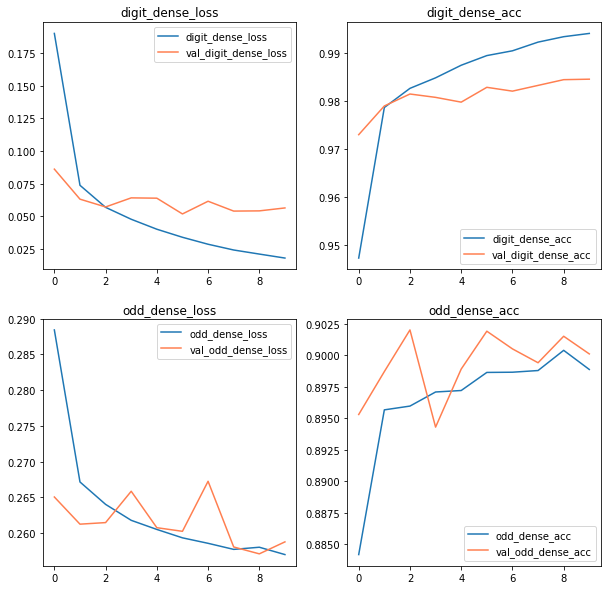

In [38]:
import matplotlib.pylab as plt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

ax1.plot(history.history['digit_dense_loss'], label='digit_dense_loss')
ax1.plot(history.history['val_digit_dense_loss'], label='val_digit_dense_loss', color='coral')
ax1.legend()
ax1.set_title('digit_dense_loss')

ax2.plot(history.history['digit_dense_acc'], label='digit_dense_acc')
ax2.plot(history.history['val_digit_dense_acc'], label='val_digit_dense_acc', color='coral')
ax2.legend()
ax2.set_title('digit_dense_acc')

ax3.plot(history.history['odd_dense_loss'], label='odd_dense_loss')
ax3.plot(history.history['val_odd_dense_loss'], label='val_odd_dense_loss', color='coral')
ax3.legend()
ax3.set_title('odd_dense_loss')

ax4.plot(history.history['odd_dense_acc'], label='odd_dense_acc')
ax4.plot(history.history['val_odd_dense_acc'], label='val_odd_dense_acc', color='coral')
ax4.legend()
ax4.set_title('odd_dense_acc')

plt.show()

## 4. Transfer Learning

In [39]:
base_model_output = model.get_layer('flatten_layer').output

base_model = Model(inputs=model.input, outputs=base_model_output, name='base')
base_model.summary()

Model: "base"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_layer (Conv2D)        (None, 26, 26, 32)        320       
_________________________________________________________________
maxpool_layer (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_layer (Flatten)      (None, 5408)              0         
Total params: 320
Trainable params: 320
Non-trainable params: 0
_________________________________________________________________


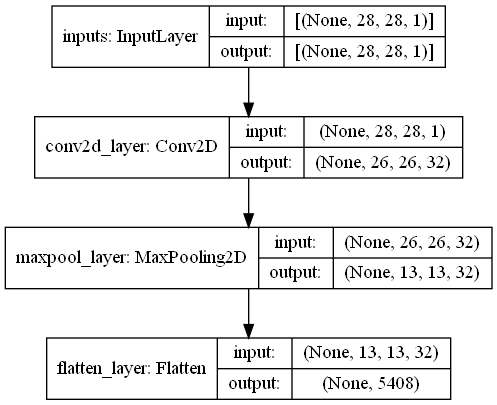

In [40]:
from tensorflow.python.keras.utils.vis_utils import plot_model
plot_model(base_model, show_shapes=True, show_layer_names=True, to_file='base_model.png')

In [41]:
# Sequential API
from tensorflow.keras.models import Sequential

digit_model = Sequential([
    base_model,
    Dense(10, activation='softmax')
])
digit_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
base (Functional)            (None, 5408)              320       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                54090     
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________


In [42]:
# compile
digit_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

# fit
history = digit_model.fit(x_train_in, y_train, validation_data=(x_valid_in, y_valid), epochs=10)

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1285 - acc: 0.9636 - val_loss: 0.0576 - val_acc: 0.9814
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0571 - acc: 0.9829 - val_loss: 0.0554 - val_acc: 0.9810
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0440 - acc: 0.9867 - val_loss: 0.0510 - val_acc: 0.9835
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0360 - acc: 0.9888 - val_loss: 0.0531 - val_acc: 0.9830
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0291 - acc: 0.9913 - val_loss: 0.0526 - val_acc: 0.9846
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0246 - acc: 0.9923 - val_loss: 0.0541 - val_acc: 0.9835
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0201 - acc: 0.9940 - val_loss: 0.0541 - val_acc: 0.9842
Epoch 8/10
1875/1875 [==============================] - 4s 2ms

In [43]:
digit_model.evaluate(x_valid_in, y_valid)

313/313 [==============================] - 1s 2ms/step - loss: 0.0573 - acc: 0.9832


[0.05733181908726692, 0.9832000136375427]

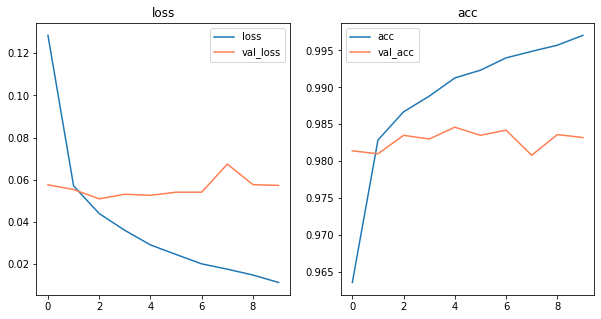

In [44]:
import matplotlib.pylab as plt

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax1.plot(history.history['loss'], label='loss')
ax1.plot(history.history['val_loss'], label='val_loss', color='coral')
ax1.legend()
ax1.set_title('loss')

ax2.plot(history.history['acc'], label='acc')
ax2.plot(history.history['val_acc'], label='val_acc', color='coral')
ax2.legend()
ax2.set_title('acc')

plt.show()

In [45]:
# Freeze model

base_model_frozen = Model(inputs=model.input, outputs=base_model_output, name='base_frozen')
base_model_frozen.trainable = False
base_model_frozen.summary()

Model: "base_frozen"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_layer (Conv2D)        (None, 26, 26, 32)        320       
_________________________________________________________________
maxpool_layer (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_layer (Flatten)      (None, 5408)              0         
Total params: 320
Trainable params: 0
Non-trainable params: 320
_________________________________________________________________


In [46]:
# Functional API
dense_output = Dense(10, activation='softmax')(base_model_frozen.output)
digit_model_frozen = Model(inputs=base_model_frozen.input, outputs=dense_output)
digit_model_frozen.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_layer (Conv2D)        (None, 26, 26, 32)        320       
_________________________________________________________________
maxpool_layer (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_layer (Flatten)      (None, 5408)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                54090     
Total params: 54,410
Trainable params: 54,090
Non-trainable params: 320
_________________________________________________________________


In [47]:
# compile
digit_model_frozen.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

# fit
history = digit_model_frozen.fit(x_train_in, y_train, 
                                 validation_data=(x_valid_in, y_valid), 
                                 epochs=10)

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1155 - acc: 0.9687 - val_loss: 0.0601 - val_acc: 0.9817
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0484 - acc: 0.9862 - val_loss: 0.0524 - val_acc: 0.9831
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0360 - acc: 0.9889 - val_loss: 0.0482 - val_acc: 0.9848
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0276 - acc: 0.9918 - val_loss: 0.0477 - val_acc: 0.9847
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0221 - acc: 0.9934 - val_loss: 0.0566 - val_acc: 0.9817
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0183 - acc: 0.9945 - val_loss: 0.0541 - val_acc: 0.9829
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0147 - acc: 0.9959 - val_loss: 0.0518 - val_acc: 0.9848
Epoch 8/10
1875/1875 [==============================] - 4s 2ms

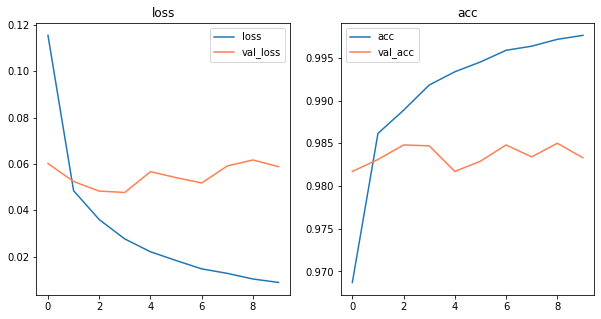

In [48]:
import matplotlib.pylab as plt

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax1.plot(history.history['loss'], label='loss')
ax1.plot(history.history['val_loss'], label='val_loss', color='coral')
ax1.legend()
ax1.set_title('loss')

ax2.plot(history.history['acc'], label='acc')
ax2.plot(history.history['val_acc'], label='val_acc', color='coral')
ax2.legend()
ax2.set_title('acc')

plt.show()

In [49]:
# Freeze Layer (Conv2D, in Basemodel)

base_model_frozen2 = Model(inputs=model.input, outputs=base_model_output, name='base_frozen2')
base_model_frozen2.get_layer('conv2d_layer').trainable=False
base_model_frozen2.summary()

Model: "base_frozen2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_layer (Conv2D)        (None, 26, 26, 32)        320       
_________________________________________________________________
maxpool_layer (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_layer (Flatten)      (None, 5408)              0         
Total params: 320
Trainable params: 0
Non-trainable params: 320
_________________________________________________________________


In [50]:
dense_output2 = Dense(10, activation='softmax')(base_model_frozen2.output)
digit_model_frozen2 = Model(inputs=base_model_frozen2.input, outputs=dense_output2)
digit_model_frozen2.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_layer (Conv2D)        (None, 26, 26, 32)        320       
_________________________________________________________________
maxpool_layer (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_layer (Flatten)      (None, 5408)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                54090     
Total params: 54,410
Trainable params: 54,090
Non-trainable params: 320
_________________________________________________________________


In [51]:
# compile
digit_model_frozen2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

# fit
history = digit_model_frozen2.fit(x_train_in, y_train, 
                                 validation_data=(x_valid_in, y_valid), 
                                 epochs=10)

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1151 - acc: 0.9691 - val_loss: 0.0561 - val_acc: 0.9820
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0481 - acc: 0.9862 - val_loss: 0.0543 - val_acc: 0.9826
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0357 - acc: 0.9893 - val_loss: 0.0500 - val_acc: 0.9845
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0277 - acc: 0.9914 - val_loss: 0.0568 - val_acc: 0.9824
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0221 - acc: 0.9930 - val_loss: 0.0474 - val_acc: 0.9853
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0187 - acc: 0.9945 - val_loss: 0.0541 - val_acc: 0.9839
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0148 - acc: 0.9955 - val_loss: 0.0508 - val_acc: 0.9840
Epoch 8/10
1875/1875 [==============================] - 4s 2ms

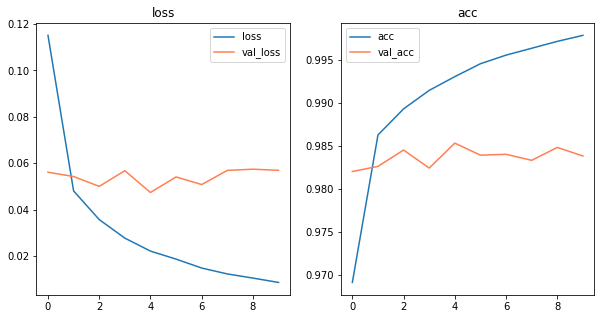

In [52]:
import matplotlib.pylab as plt

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax1.plot(history.history['loss'], label='loss')
ax1.plot(history.history['val_loss'], label='val_loss', color='coral')
ax1.legend()
ax1.set_title('loss')

ax2.plot(history.history['acc'], label='acc')
ax2.plot(history.history['val_acc'], label='val_acc', color='coral')
ax2.legend()
ax2.set_title('acc')

plt.show()